In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph

UsageError: %%capture is a cell magic, but the cell body is empty.


In [1]:
import os, getpass

def _set_env(var: str):
    if not os.getenv(var):
        os.environ[var] = getpass.getpass(f"Enter {var} (will not be shown): ")

_set_env("OPENAI_API_KEY")

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [35]:
from langchain_openai import ChatOpenAI

def multiply(x: int, y:int) -> int:
    """ Multiply two numbers.
        Args: 
            x: First number.
            y: Second number.
    """
    return x*y

def add(x: int, y:int) -> int:
    """ Add two numbers.
        Args:
            x: First number.
            y: Second number.
    """
    return x+y

def subtract(x: int, y:int) -> int:
    """ Subtract two numbers.
        Args:
            x: First number.
            y: Second number.
    """
    return x-y

def divide(x: int, y: int) -> float:
    """ Divide two numbers.
        Args:
            x: First number.
            y: Second number.
        Raises:
            ZeroDivisionError: If y is zero
    """
    if y == 0:
        raise ZeroDivisionError("Cannot divide by zero")
    return x / y

tools = [ add, subtract, multiply, divide ]
llm = ChatOpenAI(model="gpt-4.1")

llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [36]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage

sys_message = SystemMessage(content= "You are a helpful assistant that can perform basic math operations. You can add, subtract, multiply, and divide numbers.")
    
def assistant(state: MessagesState) -> str:
    return { "messages" : [llm_with_tools.invoke(sys_message + state["messages"])]}

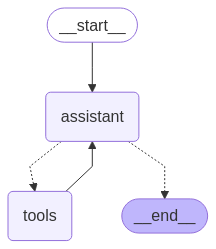

In [37]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",            
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
    )
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [38]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 7. Subtract the output by 2.")]
messages = react_graph.invoke({"messages": messages})

ValueError: Invalid input type <class 'langchain_core.prompts.chat.ChatPromptTemplate'>. Must be a PromptValue, str, or list of BaseMessages.

In [ ]:
for m in messages['messages']:
    m.pretty_print()